In [1]:
# load in required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import shap
import re
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, linear_model
from xgboost import XGBClassifier, XGBRegressor
import statsmodels.formula.api as smf
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
city='Berlin'

print(city)

if city=='Germany_other':
        city0='Dresden'
        df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
        print(len(df0.columns), 'columns in the data for ', city0)
        df0['City']=city0
        df_all=df0.copy()

        cities=['Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
        for city1 in cities:
            print(city)
            df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
            print(len(df1.columns), 'columns in the data for ', city1)
            df1['City']=city1
            if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                print(len(df_all), 'rows in the combined dataframe')
        df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
        df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
        df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
        df=df_all.copy()
elif city=='France_other':
        city0='Clermont'
        df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
        df0.drop(columns=['IncomeDetailed', 'IncomeHarmonised','Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone', 'Sample','Sector_Zone', 'Zone','geo_unit','N_Stops', 'N_Legs'],errors='ignore',inplace=True)
        print(len(df0.columns), 'columns in the data for ', city0)
        df0['City']=city0
        df_all=df0.copy()

        cities=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon']
        for city1 in cities:
            print(city1)
            df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
            df1.drop(columns=['IncomeDetailed', 'IncomeHarmonised', 'Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone',  'Sample','Sector_Zone', 'Zone','geo_unit',
                            'Commune', 'Des_Cell', 'Grid_Cell', 'NoMobilityConstraints','Ori_Cell','N_Stops', 'N_Legs'],errors='ignore',inplace=True) # plus spme non-shared Paris variables
            print(len(df1.columns), 'columns in the data for ', city1)
            df1['City']=city1
            if len(df1.columns==df_all.columns):
                df1=df1[df_all.columns] # this is required for Paris, where the same columns exist after the dropping above, but the order is different
                df_all=pd.concat([df_all,df1])
                print(city1, 'added.')
                print(len(df_all), 'rows in the combined dataframe')
        df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(str)
        df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(str)
        df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
        df=df_all.copy()

else: df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


# here we limit to trips starting at home
df['Start']=df['trip_type_all'].str[:4]
df=df.loc[df['Start']=='Home',]

df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
'HHSize', #'IncomeDetailed', 'HHType', # household details
'Sex', 'Occupation', 'Education','Age', # personal details, only use age for now, not age group, check later what works beter
'UrbPopDensity_origin', 'DistSubcenter_origin', 'DistCenter_origin','UrbBuildDensity_origin',
'IntersecDensity_origin', 'street_length_origin', 'bike_lane_share_origin',
'LU_UrbFab_origin','LU_Comm_origin',    # urban form features, land-use features are now all from UA. removed 'LU_Road_origin', 'LU_Road_dest', 'LU_Urban_origin','LU_Urban_dest', 
# target: Trip_Distance
'Mode')
]

df['Mode_num']=0
# car, bike, foot, transit
df.loc[df['Mode']=='Car','Mode_num']=0
df.loc[df['Mode']=='Bike','Mode_num']=1
df.loc[df['Mode']=='Foot','Mode_num']=2
df.loc[df['Mode']=='Transit','Mode_num']=3

df.drop(columns='Mode',inplace=True)

df.loc[df['Education'].isin(['Secondary+BAC','Secondary+Matura']),'Education']='Secondary'

# identify the feature columns
N_non_feature=6 # how many non-features are at the start of the df
cols=df.columns
newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureM' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
# change column names
df.set_axis(newcols,axis=1,inplace=True)
df = df.reset_index(drop=True)
df.dropna(inplace=True)
df0=df.copy()

# convert  all categorical variables to dummies
df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureM" in col]]
for col in df_Cat:
    dum=pd.get_dummies(df[[col]])
    df = pd.concat([df, dum], axis = 1)
    # remove the original categorical columns
df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
# HPO with full dataset, grouping by individual person
target = 'Mode_num'
N=len(df)

# Define the parameter space to be considered
PS = {"learning_rate": [0.1 ,0.15,0.2,0.3], 
                "n_estimators": [100, 200, 300, 400],
                "max_depth":[3, 4, 5]}

X=df[[col for col in df.columns if "FeatureM" in col]]
y = df[target]
fp='../outputs/ML_Results/shap/mode_common/' + city + '.pkl'
with open(fp, 'rb') as f:
    shap_values=pickle.load(f)

fp='../outputs/ML_Results/shap/mode_common/' + city + '_importance.pkl'
with open(fp, 'rb') as f:
    importance_df=pickle.load(f)
X_disp=[re.sub('FeatureM_','', x) for x in X.sort_index().columns]
col_dict= {'DistCenter_origin':'Dist. to city center','DistSubcenter_origin':'Dist. to subenter', 'UrbPopDensity_origin':'Population density','UrbBuildDensity_origin':'Built-up density','ParkingAvailable_Dest':'Parking available',
    'IntersecDensity_origin':'Intersection density','LU_Comm_origin':'Commercial area','LU_UrbFab_origin':'Urban Fabric area','street_length_origin':'Avg. street length','bike_lane_share_origin':'Cycle lanes',
    'Trip_Purpose_Agg_Home↔Work':'Commute trip', 'Trip_Purpose_Agg_Home↔Companion':'Companion trip', 'TravelAlone':'Solo trip','Trip_Purpose_Agg_Home↔Leisure':'Leisure trip','Trip_Purpose_Agg_Home↔Shopping':'Shopping trip','Trip_Purpose_Agg_Home↔School':'School trip',
    'Trip_Time_Evening':'Evening trip','Trip_Time_AM_Rush':'Morning trip',
    'Season_Winter':'Winter season','MeanTime2Transit_origin':'Time to transit', #'diff':'Elevation_diff',
    'Trip_Distance':'Trip distance','CarOwnershipHH':'Car ownership','Occupation_Student_School':'School Student',
    'Age':'Age','Sex':'Sex','HHSize':'Household size','IncomeDescriptiveNumeric':'Income','IncomeDetailed_Numeric':'Income',
    'Education_University':'University education', 'Occupation_Employed_FullTime':'Employed'}
X_lab=[*map(col_dict.get, X_disp)]

i=X.columns.get_loc(feature_name)

car=shap_values[0]
walk=shap_values[2]
bike=shap_values[1]
trans=shap_values[3]

# first for car trips
values=car[:,i]
data=X.sort_index().iloc[:,i]
xmean=[]
ymean=[]
y0=[]

dftemp=pd.DataFrame({'d':data,'v':values})
dftemp=dftemp.groupby('d')['v'].mean().reset_index()
dftemp['v0']=0
xmean.append(dftemp['d'].values)
ymean.append(dftemp['v'].values)
y0.append(dftemp['v0'].values)

# xs=data
# ys=values

x=xmean[0]
y1=y0[0]
y2=ymean[0]
xn=pd.DataFrame(X[feature_name].value_counts())
xn.reset_index(inplace=True)
xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
df_mode_feature.drop(columns=feature_label,inplace=True)
df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>39,]
df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Car','Feature_value':x,'Shap_y':y2,'Zero':0})
df_combine=pd.concat([df_combine,df_mode_feature])

# then bike trips
values=bike[:,i]
data=X.sort_index().iloc[:,i]
xmean=[]
ymean=[]
y0=[]


dftemp=pd.DataFrame({'d':data,'v':values})
dftemp=dftemp.groupby('d')['v'].mean().reset_index()
dftemp['v0']=0
xmean.append(dftemp['d'].values)
ymean.append(dftemp['v'].values)
y0.append(dftemp['v0'].values)

# xs=data
# ys=values

x=xmean[0]
y1=y0[0]
y2=ymean[0]
xn=pd.DataFrame(X[feature_name].value_counts())
xn.reset_index(inplace=True)
xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
df_mode_feature.drop(columns=feature_label,inplace=True)
df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>39,]
df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Bike','Feature_value':x,'Shap_y':y2,'Zero':0})
df_combine=pd.concat([df_combine,df_mode_feature])

# then foot trips
values=walk[:,i]
data=X.sort_index().iloc[:,i]
xmean=[]
ymean=[]
y0=[]


dftemp=pd.DataFrame({'d':data,'v':values})
dftemp=dftemp.groupby('d')['v'].mean().reset_index()
dftemp['v0']=0
xmean.append(dftemp['d'].values)
ymean.append(dftemp['v'].values)
y0.append(dftemp['v0'].values)

# xs=data
# ys=values

x=xmean[0]
y1=y0[0]
y2=ymean[0]
xn=pd.DataFrame(X[feature_name].value_counts())
xn.reset_index(inplace=True)
xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
df_mode_feature.drop(columns=feature_label,inplace=True)
df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>39,]
df_combine=pd.concat([df_combine,df_mode_feature])

# then transit trips
values=trans[:,i]
data=X.sort_index().iloc[:,i]
xmean=[]
ymean=[]
y0=[]


dftemp=pd.DataFrame({'d':data,'v':values})
dftemp=dftemp.groupby('d')['v'].mean().reset_index()
dftemp['v0']=0
xmean.append(dftemp['d'].values)
ymean.append(dftemp['v'].values)
y0.append(dftemp['v0'].values)

# xs=data
# ys=values

x=xmean[0]
y1=y0[0]
y2=ymean[0]

xn=pd.DataFrame(X[feature_name].value_counts())
xn.reset_index(inplace=True)
xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
df_mode_feature.drop(columns=feature_label,inplace=True)
df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>39,]

df_combine=pd.concat([df_combine,df_mode_feature])

Berlin


NameError: name 'feature_name' is not defined

In [15]:
# feature_name='FeatureM_Trip_Distance'
# feature_label='Trip Distance (km)'
feature_name='FeatureM_Age'
feature_label='Age'

# feature_name='FeatureM_UrbPopDensity_origin'
# feature_label='Population Density (per/km2)'
#feature_name='FeatureM_DistCenter_origin'
# feature_label='Dist. to city center (km)'

df_combine=pd.DataFrame(columns=['City','Feature','Mode','Feature_value','Shap_y','Zero'])

for city in ['Berlin','France_other','Germany_other','Madrid','Paris','Wien']:
    print(city)

    if city=='Germany_other':
            city0='Dresden'
            df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
            print(len(df0.columns), 'columns in the data for ', city0)
            df0['City']=city0
            df_all=df0.copy()

            cities=['Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
            for city1 in cities:
                print(city)
                df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
                print(len(df1.columns), 'columns in the data for ', city1)
                df1['City']=city1
                if len(df1.columns==df_all.columns):
                    df_all=pd.concat([df_all,df1])
                    print(city1, 'added.')
                    print(len(df_all), 'rows in the combined dataframe')
            df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
            df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(int).astype(str)
            df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(int).astype(str)
            df=df_all.copy()
    elif city=='France_other':
            city0='Clermont'
            df0=pd.read_csv('../outputs/Combined/' + city0 + '_UF.csv')
            df0.drop(columns=['IncomeDetailed', 'IncomeHarmonised','Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone', 'Sample','Sector_Zone', 'Zone','geo_unit','N_Stops', 'N_Legs'],errors='ignore',inplace=True)
            print(len(df0.columns), 'columns in the data for ', city0)
            df0['City']=city0
            df_all=df0.copy()

            cities=['Toulouse','Montpellier','Lyon','Nantes','Nimes','Lille','Dijon']
            for city1 in cities:
                print(city1)
                df1=pd.read_csv('../outputs/Combined/' + city1 + '_UF.csv')
                df1.drop(columns=['IncomeDetailed', 'IncomeHarmonised', 'Des_Sec_Zone', 'Month', 'Ori_Sec_Zone','Res_Sec_Zone',  'Sample','Sector_Zone', 'Zone','geo_unit',
                                'Commune', 'Des_Cell', 'Grid_Cell', 'NoMobilityConstraints','Ori_Cell','N_Stops', 'N_Legs'],errors='ignore',inplace=True) # plus spme non-shared Paris variables
                print(len(df1.columns), 'columns in the data for ', city1)
                df1['City']=city1
                if len(df1.columns==df_all.columns):
                    df1=df1[df_all.columns] # this is required for Paris, where the same columns exist after the dropping above, but the order is different
                    df_all=pd.concat([df_all,df1])
                    print(city1, 'added.')
                    print(len(df_all), 'rows in the combined dataframe')
            df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(str)
            df_all['HH_PNR']=df_all['City']+'_'+df_all['HH_PNR'].astype(str)
            df_all['HH_P_WNR']=df_all['City']+'_'+df_all['HH_P_WNR'].astype(str)
            df=df_all.copy()

    else: df=pd.read_csv('../outputs/Combined/' + city + '_UF.csv')


    # here we limit to trips starting at home
    df['Start']=df['trip_type_all'].str[:4]
    df=df.loc[df['Start']=='Home',]

    df=df.loc[:,('HH_P_WNR','HH_PNR', 'HHNR','Ori_geocode', 'Des_geocode','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'Trip_Time', 'Season','Trip_Purpose_Agg','CarOwnershipHH', 'Trip_Distance', # trip details, keep number of accompanying householders now as 'TravelAlone', but remove n_others_car as it gives away the mode.     
    'HHSize', #'IncomeDetailed', 'HHType', # household details
    'Sex', 'Occupation', 'Education','Age', # personal details, only use age for now, not age group, check later what works beter
    'UrbPopDensity_origin', 'DistSubcenter_origin', 'DistCenter_origin','UrbBuildDensity_origin',
    'IntersecDensity_origin', 'street_length_origin', 'bike_lane_share_origin',
    'LU_UrbFab_origin','LU_Comm_origin',    # urban form features, land-use features are now all from UA. removed 'LU_Road_origin', 'LU_Road_dest', 'LU_Urban_origin','LU_Urban_dest', 
    # target: Trip_Distance
    'Mode')
    ]

    df['Mode_num']=0
    # car, bike, foot, transit
    df.loc[df['Mode']=='Car','Mode_num']=0
    df.loc[df['Mode']=='Bike','Mode_num']=1
    df.loc[df['Mode']=='Foot','Mode_num']=2
    df.loc[df['Mode']=='Transit','Mode_num']=3

    df.drop(columns='Mode',inplace=True)

    df.loc[df['Education'].isin(['Secondary+BAC','Secondary+Matura']),'Education']='Secondary'

    # identify the feature columns
    N_non_feature=6 # how many non-features are at the start of the df
    cols=df.columns
    newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureM' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
    # change column names
    df.set_axis(newcols,axis=1,inplace=True)
    df = df.reset_index(drop=True)
    df.dropna(inplace=True)
    df0=df.copy()

    # convert  all categorical variables to dummies
    df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureM" in col]]
    for col in df_Cat:
        dum=pd.get_dummies(df[[col]])
        df = pd.concat([df, dum], axis = 1)
        # remove the original categorical columns
    df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
    # HPO with full dataset, grouping by individual person
    target = 'Mode_num'
    N=len(df)

    # Define the parameter space to be considered
    PS = {"learning_rate": [0.1 ,0.15,0.2,0.3], 
                    "n_estimators": [100, 200, 300, 400],
                    "max_depth":[3, 4, 5]}

    X=df[[col for col in df.columns if "FeatureM" in col]]
    y = df[target]
    fp='../outputs/ML_Results/shap/mode_common/' + city + '.pkl'
    with open(fp, 'rb') as f:
        shap_values=pickle.load(f)

    fp='../outputs/ML_Results/shap/mode_common/' + city + '_importance.pkl'
    with open(fp, 'rb') as f:
        importance_df=pickle.load(f)
    X_disp=[re.sub('FeatureM_','', x) for x in X.sort_index().columns]
    col_dict= {'DistCenter_origin':'Dist. to city center','DistSubcenter_origin':'Dist. to subenter', 'UrbPopDensity_origin':'Population density','UrbBuildDensity_origin':'Built-up density','ParkingAvailable_Dest':'Parking available',
        'IntersecDensity_origin':'Intersection density','LU_Comm_origin':'Commercial area','LU_UrbFab_origin':'Urban Fabric area','street_length_origin':'Avg. street length','bike_lane_share_origin':'Cycle lanes',
        'Trip_Purpose_Agg_Home↔Work':'Commute trip', 'Trip_Purpose_Agg_Home↔Companion':'Companion trip', 'TravelAlone':'Solo trip','Trip_Purpose_Agg_Home↔Leisure':'Leisure trip','Trip_Purpose_Agg_Home↔Shopping':'Shopping trip','Trip_Purpose_Agg_Home↔School':'School trip',
        'Trip_Time_Evening':'Evening trip','Trip_Time_AM_Rush':'Morning trip',
        'Season_Winter':'Winter season','MeanTime2Transit_origin':'Time to transit', #'diff':'Elevation_diff',
        'Trip_Distance':'Trip distance','CarOwnershipHH':'Car ownership','Occupation_Student_School':'School Student',
        'Age':'Age','Sex':'Sex','HHSize':'Household size','IncomeDescriptiveNumeric':'Income','IncomeDetailed_Numeric':'Income',
        'Education_University':'University education', 'Occupation_Employed_FullTime':'Employed'}
    X_lab=[*map(col_dict.get, X_disp)]

    i=X.columns.get_loc(feature_name)

    car=shap_values[0]
    walk=shap_values[2]
    bike=shap_values[1]
    trans=shap_values[3]

    count_thres=79

    # first for car trips
    values=car[:,i]
    data=X.sort_index().iloc[:,i]
    xmean=[]
    ymean=[]
    y0=[]

    dftemp=pd.DataFrame({'d':data,'v':values})
    dftemp=dftemp.groupby('d')['v'].mean().reset_index()
    dftemp['v0']=0
    xmean.append(dftemp['d'].values)
    ymean.append(dftemp['v'].values)
    y0.append(dftemp['v0'].values) 

    x=xmean[0]
    y1=y0[0]
    y2=ymean[0]
    xn=pd.DataFrame(X[feature_name].value_counts())
    xn.reset_index(inplace=True)
    xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

    df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Car','Feature_value':x,'Shap_y':y2,'Zero':0})

    df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
    df_mode_feature.drop(columns=feature_label,inplace=True)
    df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
    #df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Car','Feature_value':x,'Shap_y':y2,'Zero':0})
    df_combine=pd.concat([df_combine,df_mode_feature])

    # then bike trips
    values=bike[:,i]
    data=X.sort_index().iloc[:,i]
    xmean=[]
    ymean=[]
    y0=[]


    dftemp=pd.DataFrame({'d':data,'v':values})
    dftemp=dftemp.groupby('d')['v'].mean().reset_index()
    dftemp['v0']=0
    xmean.append(dftemp['d'].values)
    ymean.append(dftemp['v'].values)
    y0.append(dftemp['v0'].values)

    # xs=data
    # ys=values

    x=xmean[0]
    y1=y0[0]
    y2=ymean[0]
    xn=pd.DataFrame(X[feature_name].value_counts())
    xn.reset_index(inplace=True)
    xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

    df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Bike','Feature_value':x,'Shap_y':y2,'Zero':0})

    df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
    df_mode_feature.drop(columns=feature_label,inplace=True)
    df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
    #df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Bike','Feature_value':x,'Shap_y':y2,'Zero':0})
    df_combine=pd.concat([df_combine,df_mode_feature])

    # then foot trips
    values=walk[:,i]
    data=X.sort_index().iloc[:,i]
    xmean=[]
    ymean=[]
    y0=[]

    dftemp=pd.DataFrame({'d':data,'v':values})
    dftemp=dftemp.groupby('d')['v'].mean().reset_index()
    dftemp['v0']=0
    xmean.append(dftemp['d'].values)
    ymean.append(dftemp['v'].values)
    y0.append(dftemp['v0'].values)

    # xs=data
    # ys=values

    x=xmean[0]
    y1=y0[0]
    y2=ymean[0]
    xn=pd.DataFrame(X[feature_name].value_counts())
    xn.reset_index(inplace=True)
    xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

    df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Foot','Feature_value':x,'Shap_y':y2,'Zero':0})

    df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
    df_mode_feature.drop(columns=feature_label,inplace=True)
    df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]
    df_combine=pd.concat([df_combine,df_mode_feature])

    # then transit trips
    values=trans[:,i]
    data=X.sort_index().iloc[:,i]
    xmean=[]
    ymean=[]
    y0=[]


    dftemp=pd.DataFrame({'d':data,'v':values})
    dftemp=dftemp.groupby('d')['v'].mean().reset_index()
    dftemp['v0']=0
    xmean.append(dftemp['d'].values)
    ymean.append(dftemp['v'].values)
    y0.append(dftemp['v0'].values)

    # xs=data
    # ys=values

    x=xmean[0]
    y1=y0[0]
    y2=ymean[0]

    xn=pd.DataFrame(X[feature_name].value_counts())
    xn.reset_index(inplace=True)
    xn.rename(columns={'index':feature_label,feature_name:'count'},inplace=True)

    df_mode_feature=pd.DataFrame({'City':city,'Feature':feature_name.replace('FeatureM_',''),'Mode':'Transit','Feature_value':x,'Shap_y':y2,'Zero':0})

    df_mode_feature=df_mode_feature.merge(xn,left_on='Feature_value',right_on=feature_label)
    df_mode_feature.drop(columns=feature_label,inplace=True)
    df_mode_feature=df_mode_feature.loc[df_mode_feature['count']>count_thres,]

    df_combine=pd.concat([df_combine,df_mode_feature])

df_combine.reset_index(inplace=True,drop=True)
df_combine['City'].replace('Wien','Vienna',inplace=True)
df_combine['City'].replace('France_other','France, other',inplace=True)
df_combine['City'].replace('Germany_other','Germany, other',inplace=True)

Berlin
France_other
74 columns in the data for  Clermont
Toulouse
74 columns in the data for  Toulouse
Toulouse added.
40299 rows in the combined dataframe
Montpellier
74 columns in the data for  Montpellier
Montpellier added.
63973 rows in the combined dataframe
Lyon
74 columns in the data for  Lyon
Lyon added.
114184 rows in the combined dataframe
Nantes
74 columns in the data for  Nantes
Nantes added.
147302 rows in the combined dataframe
Nimes
74 columns in the data for  Nimes
Nimes added.
155730 rows in the combined dataframe
Lille
74 columns in the data for  Lille
Lille added.
186657 rows in the combined dataframe
Dijon
74 columns in the data for  Dijon
Dijon added.
199788 rows in the combined dataframe
Germany_other
90 columns in the data for  Dresden
Germany_other
90 columns in the data for  Leipzig
Leipzig added.
20571 rows in the combined dataframe
Germany_other
90 columns in the data for  Magdeburg
Magdeburg added.
29614 rows in the combined dataframe
Germany_other
90 column

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


Madrid


Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.


Paris
Wien


<AxesSubplot:title={'center':'Car'}, xlabel='Age', ylabel='SHAP (mode Prob.)'>

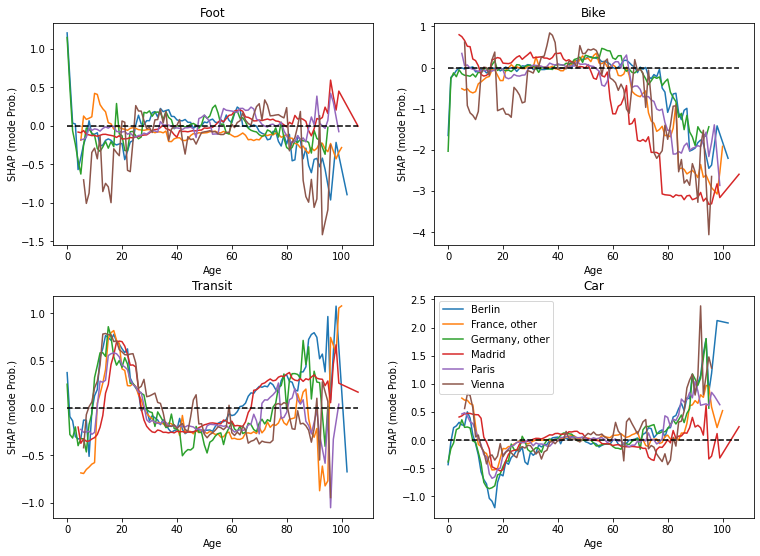

In [37]:
# # plots for individual modes, with data for each city in each subplot
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
# fig.tight_layout(pad=3.0)

# ax1 = plt.subplot(221)
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Foot',], x='Feature_value', y='Shap_y', hue='City').set(title='Foot',xlabel=feature_label, ylabel='SHAP (mode Prob.)')
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Foot',], x='Feature_value', y='Zero',color='black',linestyle='dashed')
# ax1.get_legend().remove()

# ax2 = plt.subplot(222)
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Bike',], x='Feature_value', y='Shap_y', hue='City').set(title='Bike',xlabel=feature_label, ylabel='SHAP (mode Prob.)')
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Bike',], x='Feature_value', y='Zero',color='black',linestyle='dashed')
# ax2.get_legend().remove()

# ax3 = plt.subplot(223)
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Transit',], x='Feature_value', y='Shap_y', hue='City').set(title='Transit',xlabel=feature_label, ylabel='SHAP (mode Prob.)')
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Transit',], x='Feature_value', y='Zero',color='black',linestyle='dashed')
# ax3.get_legend().remove()

# ax1 = plt.subplot(224)
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Car',], x='Feature_value', y='Shap_y', hue='City').set(title='Car',xlabel=feature_label, ylabel='SHAP (mode Prob.)')
# sns.lineplot(data=df_combine.loc[df_combine['Mode']=='Car',], x='Feature_value', y='Zero',color='black',linestyle='dashed')

# plt.savefig('../outputs/ML_Results/result_figures/mode_common/' + feature_label +  '_all.png',facecolor='w',dpi=65,bbox_inches='tight')
# plt.close() 

In [16]:
# summarise by binned values
b=[w for w in range(-1,110,3)]
df_combine['Group'] = pd.cut(df_combine['Feature_value'], bins=b)
df_combine['Group_mid']=[f.mid for f in df_combine['Group']]
df_combine


,City,Feature,Mode,Feature_value,Shap_y,Zero,count,Group,Group_mid
0,Berlin,Age,Car,0,-0.436405,0,489.0,"(-1, 2]",0.5
1,Berlin,Age,Car,1,-0.031347,0,666.0,"(-1, 2]",0.5
2,Berlin,Age,Car,2,0.221541,0,494.0,"(-1, 2]",0.5
3,Berlin,Age,Car,3,0.252583,0,503.0,"(2, 5]",3.5
4,Berlin,Age,Car,4,0.315627,0,496.0,"(2, 5]",3.5
...,...,...,...,...,...,...,...,...,...
1871,Vienna,Age,Transit,71,-0.349632,0,118.0,"(68, 71]",69.5
1872,Vienna,Age,Transit,72,-0.360004,0,131.0,"(71, 74]",72.5
1873,Vienna,Age,Transit,73,-0.363812,0,135.0,"(71, 74]",72.5
1874,Vienna,Age,Transit,74,-0.366412,0,121.0,"(71, 74]",72.5


In [92]:
# bins = np.linspace(0, 50000, 1000)
# df_combine['DistGroup_int']=np.digitize(df_combine['Feature_value'], bins)

In [17]:
# get mean values per bin
df_mean=pd.DataFrame(df_combine.groupby(['City','Feature','Mode','Group_mid'])['Shap_y'].mean())
df_mean.reset_index(inplace=True)
df_mean['Zero']=0
if feature_label=='Trip Distance (km)':
    df_mean['Group_mid']=0.001*df_mean['Group_mid']
df_mean

,City,Feature,Mode,Group_mid,Shap_y,Zero
0,Berlin,Age,Bike,0.5,-0.687899,0
1,Berlin,Age,Bike,3.5,-0.031585,0
2,Berlin,Age,Bike,6.5,-0.019013,0
3,Berlin,Age,Bike,9.5,-0.062567,0
4,Berlin,Age,Bike,12.5,-0.078396,0
...,...,...,...,...,...,...
647,Vienna,Age,Transit,63.5,-0.235580,0
648,Vienna,Age,Transit,66.5,-0.354465,0
649,Vienna,Age,Transit,69.5,-0.348209,0
650,Vienna,Age,Transit,72.5,-0.363409,0


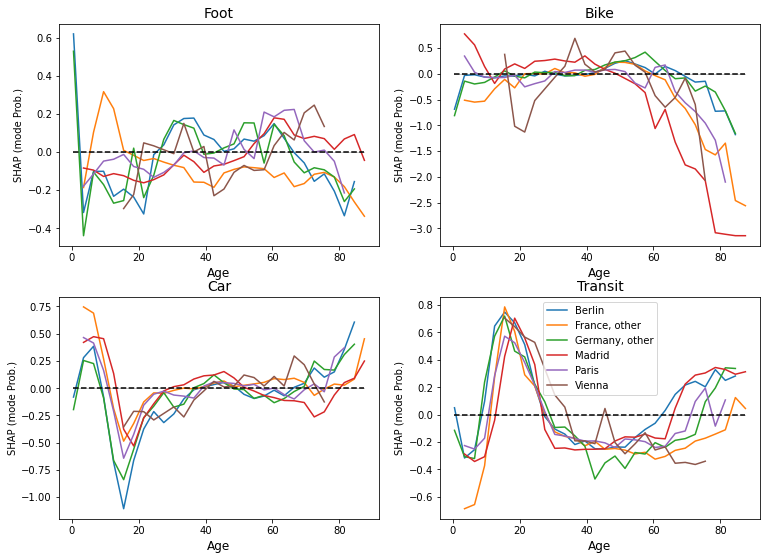

In [19]:
# plot binned values, with subplots per mode and values for each city in each subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
fig.tight_layout(pad=3.0)

ax1 = plt.subplot(221)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Foot',], x='Group_mid', y='Shap_y', hue='City').set(title='Foot',ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Foot',fontsize=14)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Foot',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax1.get_legend().remove()

ax2 = plt.subplot(222)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Bike',], x='Group_mid', y='Shap_y', hue='City').set(title='Bike', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Bike',fontsize=14)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Bike',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax2.get_legend().remove()

ax3 = plt.subplot(223)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Car',], x='Group_mid', y='Shap_y', hue='City').set(title='Car', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Car',fontsize=14)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Car',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
ax3.get_legend().remove()

ax4 = plt.subplot(224)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Transit',], x='Group_mid', y='Shap_y', hue='City').set(title='Transit', ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label,fontsize=12)
plt.title('Transit',fontsize=14)
sns.lineplot(data=df_mean.loc[df_mean['Mode']=='Transit',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
#ax4.get_legend().remove()

plt.savefig('../outputs/ML_Results/result_figures/mode_common/' + feature_label.replace(' (km)','') +  '_all_bin.png',facecolor='w',dpi=300,bbox_inches='tight')
# plt.close() 

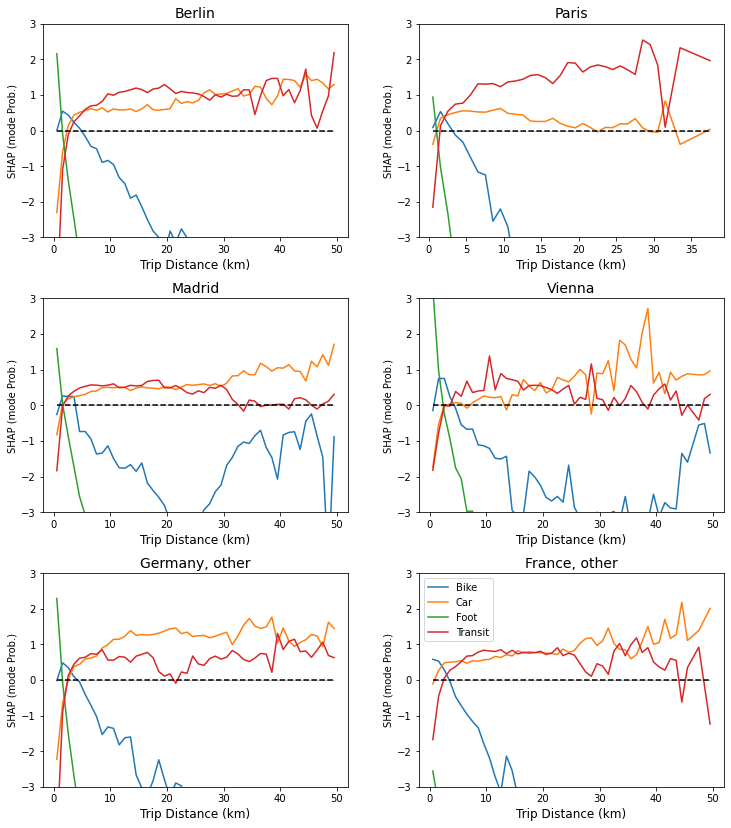

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11,12))
fig.tight_layout(pad=4.0)

ax1 = plt.subplot(321)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Berlin',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Berlin',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Berlin',fontsize=14)
ax1.get_legend().remove()

ax2 = plt.subplot(322)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Paris',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Paris',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Paris',fontsize=14)
ax2.get_legend().remove()

ax3 = plt.subplot(323)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Madrid',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Madrid',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Madrid',fontsize=14)
ax3.get_legend().remove()

ax4 = plt.subplot(324)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Vienna',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Vienna',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Vienna',fontsize=14)
ax4.get_legend().remove()

ax3 = plt.subplot(325)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Germany, other',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='Germany, other',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('Germany, other',fontsize=14)
ax3.get_legend().remove()

ax6 = plt.subplot(326)
sns.lineplot(data=df_mean.loc[df_mean['City']=='France, other',], x='Group_mid', y='Shap_y', hue='Mode').set(ylabel='SHAP (mode Prob.)')
plt.xlabel(feature_label, fontsize=12)
sns.lineplot(data=df_mean.loc[df_mean['City']=='France, other',], x='Group_mid', y='Zero',color='black',linestyle='dashed')
if feature_label=='Trip Distance (km)': plt.ylim(-3,3)
plt.title('France, other',fontsize=14)
plt.savefig('../outputs/ML_Results/result_figures/mode_common/' + feature_label.replace(' (km)','') +  '_city_bin.png',facecolor='w',dpi=300,bbox_inches='tight')
# plt.close() 